In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *

#Import thư viện cần thiết
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from math import comb
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.colors import ListedColormap
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# PySpark MLlib for machine learning
from pyspark.ml.feature import StringIndexer, PCA
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

## **1. Clustering**
- Sau khi giảm 20 đặc trưng của tập dữ liệu con xuống còn 3 chiều, tôi sẽ thực hiện phân cụm bằng thuật toán K-Means Clustering.
- K-means clustering là một kỹ thuật phân vùng, trong đó dữ liệu được chia thành K cụm riêng biệt, không chồng chéo, mỗi điểm dữ liệu thuộc về cụm có trung bình gần nhất.
- Các bước thực hiện bao gồm:
    1. Xác định số cụm bằng **phương pháp Elbow**.
    2. **Phân cụm** các điểm dữ liệu bằng thuật toán **K-means**.
    3. Vẽ **biểu đồ** các cụm.

In [ ]:
# Tạo hàm tính khoảng cách theo công thức Euclide
def calculateDistance(p1, p2):
  distance = 0
  for i in range(len(p1)):
    distance += (p1[i] - p2[i])**2
    return np.sqrt(distance)

In [ ]:
# Tạo hàm chọn trọng tâm bằng cách so sánh khoảng cách giữa điểm point và tất cả các trọng tâm
# để xem điểm point được đưa vào gần với trọng tâm nào nhất
def selectCentroid(point, centroids):
  bestIndex = 0
  Closest = float("+inf")
  for centroid in centroids:
    if isinstance(point, float):
      tempDist = calculateDistance(point, centroid[1][0])
    else:
      tempDist = calculateDistance(point, centroid[1])
    if tempDist < Closest:
      Closest = tempDist
      bestIndex = centroid[0]
  return bestIndex

In [ ]:
from operator import add
# Tính tổng các hợp phần của các điểm
def partialSum(p1,p2):
  coordinates_sum = list(map(add, p1[0], p2[0]))
  points_number = p1[1] + p2[1]
  p = [coordinates_sum, points_number]
  return p

In [ ]:
#Tính chỉ số WCSS
def computeWCSS(point_rdd, centroids):
  #Chọn điểm dữ liệu và tâm centroids gần nó trong cụm
  wcss = point_rdd.map(lambda point: (selectCentroid(point[0], centroids),point[0]))\
                  .map(lambda x: calculateDistance(x[1],centroids[x[0]][1])**2)\
                  .sum()
  return wcss

In [ ]:
#Khai báo
threshold = 0.001  # Ngưỡng hội tụ
filename = 'pca_data.txt'  # Tệp dữ liệu
max_k = 10  # Giá trị k tối đa để kiểm tra

In [ ]:
def kmean(k,lines,points_rdd):
# Khởi tạo các biến trung gian
    convergedCentroids = 0  #Số trọng tâm đã hội tụ
    centroids = []          # Trọng tâm hiện tại
    new_centroids = []      # Trọng tâm mới được tính
    iterations = 0          # Số vòng lặp
    maxIterations = 100     # Số vòng lặp tối đa
    wcss_values = []        # Biến lưu WCSS

    # Khởi tạo các trọng tâm ban đầu
    tmp = [line.split(",") for line in lines.takeSample(False, k)]   #takeSample(False, k) chọn ngẫu nhiên K điểm từ dữ liệu để làm trọng tâm ban đầu.
    for index, centroid in enumerate(tmp):
        centroids += [[index, [float(string) for string in centroid]]]   #centroids là danh sách các trọng tâm [index, tọa độ]
    print("Các trọng tâm được chọn: ", centroids)
    while maxIterations > iterations:  #Lặp cho đến khi các trọng tâm hội tụ hoặc đạt đến số vòng lặp tối đa
        iterations += 1

        # MAP: Gán dữ liệu vào cụm gần nhất
        # Hàm selectCentroid(point[0], centroids) tính khoảng cách giữa một điểm với tất cả các trọng tâm và chọn trọng tâm gần nhất.
        mapped_rdd = points_rdd.keyBy(lambda point: selectCentroid(point[0], centroids))

        # REDUCE: Tính trung bình để cập nhật trọng tâm mới
        # reduceByKey kết hợp tất cả các điểm thuộc cùng một cụm để tính tổng tọa độ và số lượng điểm.
        # Hàm partialSum(p1, p2) cộng dồn tọa độ và số lượng điểm trong cụm
        reduced_rdd = mapped_rdd.reduceByKey(lambda p1, p2: partialSum(p1, p2))
        reduced_points = reduced_rdd.collect()  # Một danh sách chứa tổng tọa độ và số lượng điểm cho từng cụm

        #Cập nhật trọng tâm mới
        # Mỗi cụm sẽ tính tọa độ trung bình bằng cách lấy tổng tọa độ chia cho số lượng điểm
        new_centroids = []
        for index, reduced_point in enumerate(reduced_points):
            converted_point = list(reduced_point)
            centroid_index = converted_point[0]
            centroid_coordinates = np.array(converted_point[1][0]) / converted_point[1][1]
            new_centroid = [centroid_index, centroid_coordinates]  #chứa trọng tâm mới được cập nhật
            new_centroids.append(new_centroid)

        # Kiểm tra hội tụ
        # So sánh k/c trọng tâm cũ với trọng tâm mới = calculateDistancs
        # Nếu k/c < threshold trọnkg tâm đã hội tụ, sau đó đếm trọng tâm hội tụ
        convergedCentroids = 0
        for index, centroid in enumerate(centroids):
            distance = calculateDistance(centroid[1], new_centroids[index][1])
            if distance < threshold:
                convergedCentroids += 1
        centroids = new_centroids   #Cập nhật lại các trọng tâm hiện tại bằng trọng tâm mới đã tính ở trên

        #Dừng vòng lặp nếu hội tụ
        percentage = len(centroids) / 100
        if convergedCentroids > percentage:
            print(f"Centroids converged for k = {k} in {iterations} iterations")
            break
    clustered_points = mapped_rdd.map(lambda x: (x[1], x[0])).collect()
    wcss = computeWCSS(points_rdd, centroids)
    return wcss,clustered_points,centroids  #Trả về chỉ số WCSS, các cụm điểm và trọng tâm cuối cùng

In [ ]:
# Tạo một SparkSession
spark = SparkSession.builder \
    .appName("WCSS") \
    .getOrCreate()
sc = SparkContext.getOrCreate()

# Tải và xử lý dữ liệu
lines = sc.textFile(filename, minPartitions = 20)
# Đọc dữ liệu vào RDD
fileRDD = lines.map(lambda line: [[float(string) for string in line.split(',')], 1])
fileRDD.cache()

PythonRDD[2] at RDD at PythonRDD.scala:53

In [ ]:
# Danh sách để lưu trữ WCSS
wcss_values = []

for k in range(1,max_k + 1):
  x,y,z = kmean(k,lines,fileRDD)
  wcss_values.append(x)
sc.stop()

Các trọng tâm được chọn:  [[0, [0.6411148325278209, -0.6655345861869296, -0.8496463698817829]]]
Centroids converged for k = 1 in 2 iterations
Các trọng tâm được chọn:  [[0, [0.8739420022253473, 0.8604621063555704, -2.8447077252082296]], [1, [-0.6206629781739894, 0.2351287849466901, 0.621158991863309]]]
Centroids converged for k = 2 in 11 iterations
Các trọng tâm được chọn:  [[0, [-2.784838933738952, -1.1209780403707794, 2.516843844751635]], [1, [2.9216115063232286, 0.2410097761967284, 2.3809178173801597]], [2, [2.18743701054042, 1.4170268463961408, -0.9577482452151208]]]
Centroids converged for k = 3 in 19 iterations
Các trọng tâm được chọn:  [[0, [0.5839057164663701, 1.834089529025823, -0.8021866463304755]], [1, [-0.2406561481922817, -2.0429890053009667, 1.8357261391394528]], [2, [1.6732832115447616, 1.3008831375157994, -1.1122226636911006]], [3, [-0.0661678744319908, -2.7565003382022906, -0.6864709971213857]]]
Centroids converged for k = 4 in 14 iterations
Các trọng tâm được chọn:  [

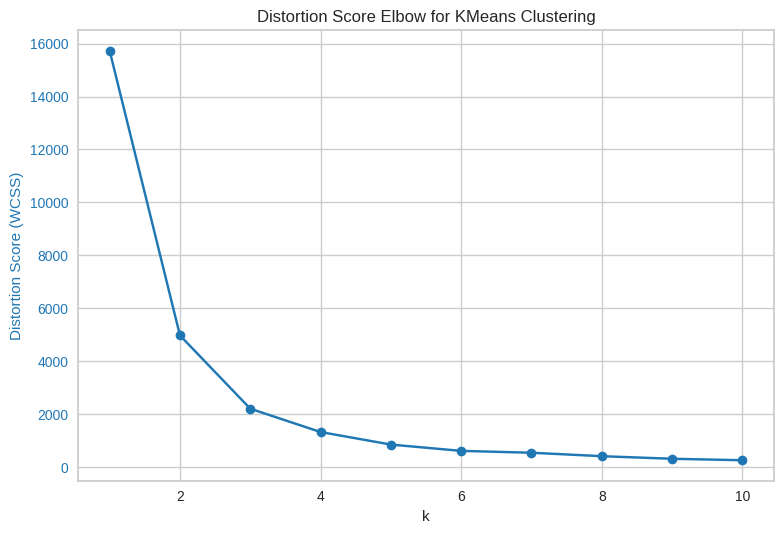

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
fig, ax1 = plt.subplots()

# Trục y thứ nhất: WCSS
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('Distortion Score (WCSS)', color=color)
ax1.plot(range(1, max_k + 1), wcss_values, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Tiêu đề và chú thích
plt.title('Distortion Score Elbow for KMeans Clustering')
fig.tight_layout()
plt.legend()
plt.show()

 **Nhận xét:**
- Theo biểu đồ Elbow trên, để xác định giá trị tối ưu cho k trong thuật toán K-Means thì sẽ chọn điểm mà đường cong bắt đầu phẳng lại (điểm khuỷu)
- Dựa trên biểu đồ thì giá trị của k trong khoảng 3 hoặc 4, vì sau đó độ chệch giảm chậm lại. Tuy nhiên ta sẽ chọn k=4 vì khi từ 4 tới 5 Distortion chỉ giảm một khoảng nhỏ hơn so với từ 3 tới 4.
=> Nhóm sẽ chọn k=4 để tính.

In [ ]:
from itertools import combinations
import numpy as np
from builtins import max

def silhouette_coefficient(clustered_points, centroids):
    """Tính toán silhouette coefficient."""
    silhouette_values = []
    for point_cluster, _ in clustered_points:
        point, cluster_index = point_cluster
        a = 0
        b = float('inf')
        cluster_distance_sum = 0
        cluster_size = 0
        for other_point_cluster, other_cluster_index in clustered_points:
            other_point, _ = other_point_cluster
            if cluster_index == other_cluster_index:
                cluster_distance_sum += calculateDistance(point, other_point)
                cluster_size += 1
            else:
                distance = calculateDistance(point, centroids[other_cluster_index][1])
                if distance < b:
                    b = distance
        a = cluster_distance_sum / cluster_size if cluster_size > 1 else 0
        silhouette = (b - a) / max(a, b)
        silhouette_values.append(silhouette)
    return np.mean(silhouette_values)


In [ ]:
def calinski_harabasz_index(clustered_points, centroids):
    """Tính chỉ số Calinski-Harabasz."""
    # Tính toán WCSS (Within Cluster Sum of Squares)
    wcss = 0
    for point_cluster, _ in clustered_points:
        point, cluster_index = point_cluster
        wcss += calculateDistance(point, centroids[cluster_index][1]) ** 2

    # Tính toán BCSS (Between Cluster Sum of Squares)
    bcss = 0
    centroid_means = np.mean([centroid[1] for centroid in centroids], axis=0)
    for centroid in centroids:
        bcss += len(clustered_points) * calculateDistance(centroid[1], centroid_means) ** 2

    # Tính Calinski-Harabasz Index
    k = len(centroids)
    n = len(clustered_points)
    calinski_harabasz = (bcss / (k - 1)) / (wcss / (n - k))
    return calinski_harabasz

Các trọng tâm được chọn:  [[0, [2.091753060150042, 1.1855056212675756, -1.1903466366201465]], [1, [-1.0052313686969925, -0.584055635270197, -1.505772079693236]], [2, [-2.496235180316404, 2.907113171856181, -2.8041580878637635]], [3, [0.3809747390412625, 1.6872562484735616, -2.18263723376354]]]
Centroids converged for k = 4 in 4 iterations
[[-0.630217357803575, -4.187782637646889, 0.4853744699830927], 1]
([[-0.5928806163868663, -0.3955403511377794, -0.9570191731033288], 1], 1)
([[-0.5705047630525357, -0.0700904321571848, 1.0893449018943395], 1], 1)
Hệ số silhouette_coefficient:  -0.4196991319507463
Hệ số calinski harabasz:  5696.976231008187


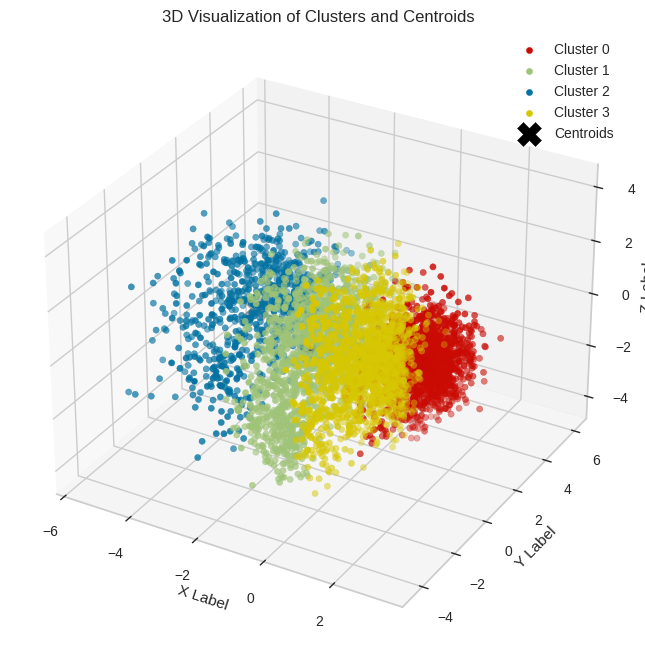

In [ ]:
# Tạo một SparkSession
spark = SparkSession.builder \
    .appName("WCSSK4") \
    .getOrCreate()
sc = SparkContext.getOrCreate()

# Tải và xử lý dữ liệu
lines = sc.textFile(filename, minPartitions = 20)
# Xử lý dữ liệu đưa về mọt
points_rdd = lines.map(lambda line: [[float(string) for string in line.split(',')], 1])
points_rdd.cache()

k = 4  # Số lượng cụm
wcss, clustered_points,centroids = kmean(k,lines, points_rdd)
print(clustered_points[0][0])
print(clustered_points[1])
print(clustered_points[2])
print("Hệ số silhouette_coefficient: ",silhouette_coefficient(clustered_points, centroids))
print("Hệ số calinski harabasz: ",calinski_harabasz_index(clustered_points, centroids))

# Vẽ biểu đồ 3D của các cụm
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
# Vẽ các điểm trong từng cụm
for cluster_index in range(k):
      cluster_points = [point[0][0] for point in clustered_points if point[1] == cluster_index]
      cluster_points = np.array(cluster_points)
      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c=colors[cluster_index % len(colors)], label=f'Cluster {cluster_index}')

# Vẽ các trọng tâm
centroid_coords = np.array([centroid[1] for centroid in centroids])
ax.scatter(centroid_coords[:, 0], centroid_coords[:, 1], centroid_coords[:, 2], s=300, c='black', marker='X', label='Centroids')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.title("3D Visualization of Clusters and Centroids")
plt.show()

In [ ]:
for i in range(10):
  print(clustered_points[i])

([[-0.630217357803575, -4.187782637646889, 0.4853744699830927], 1], 1)
([[-0.5928806163868663, -0.3955403511377794, -0.9570191731033288], 1], 1)
([[-0.5705047630525357, -0.0700904321571848, 1.0893449018943395], 1], 1)
([[-3.8156515579030432, -0.8099879984435883, 3.335909065427808], 1], 2)
([[0.8637079361617133, -1.8609408399541048, 1.0943573769285473], 1], 3)
([[-1.5232001897664005, -0.8680097172608067, 1.5835496277644865], 1], 1)
([[0.8298125783247031, -2.9609924625578232, 0.2909076743890934], 1], 3)
([[1.8364390438327896, -1.1105491940757868, 0.8657385353024135], 1], 0)
([[-1.1429872094128053, 0.2806651848958179, -0.1911676239268198], 1], 1)
([[-4.20183650196327, 1.02690051870362, 2.2143179425525283], 1], 2)


In [ ]:
lendf = len(clustered_points)
print(lendf)

4934


In [ ]:
from pyspark.sql import SparkSession

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("ADD").getOrCreate()

labels_df = spark.createDataFrame([(clustered_points[i][1],) for i in range(len(clustered_points))], ["cluster"])

labels_df.show()
print(labels_df.count())

+-------+
|cluster|
+-------+
|      1|
|      1|
|      1|
|      2|
|      3|
|      1|
|      3|
|      0|
|      1|
|      2|
|      1|
|      3|
|      3|
|      1|
|      3|
|      1|
|      3|
|      1|
|      2|
|      3|
+-------+
only showing top 20 rows

4934


In [ ]:
# data = spark.read.csv("/home/kanh/Desktop/Project/data_fixed_numeric.csv", header=True, inferSchema=True)

data = spark.read.csv("/content/data_fixed_numeric.csv", header=True, inferSchema=True)
print(data.count())

4935


In [ ]:
# Thêm cột index liên tiếp vào data và labels_df
data = data.withColumn("index", row_number().over(Window.orderBy(lit(1))))
labels_df = labels_df.withColumn("index", row_number().over(Window.orderBy(lit(1))))

# Thực hiện join hai DataFrames dựa trên cột "index"
result_df = data.join(labels_df, on="index").drop("index")

# Hiển thị kết quả
result_df.show()

+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+------+---------------+--------------+---------------+-------------+-------+
|Customer_Age|Dependent_count|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|cluster|
+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+------+---------------+----

In [ ]:
data_download = result_df.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
data_download.to_csv('data_cluster_kmeans.csv', index=False)

In [ ]:
spark.stop()

## **2. Visualization**

In [ ]:
df = pd.read_csv("/content/data_cluster_kmeans.csv")
df.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,cluster
0,57,2,48,5,2,2,2436.0,680,1756.0,1.190,...,29,0.611,0.279,0,0,0,0,0,0,1
1,62,0,49,2,3,3,1438.3,0,1438.3,1.047,...,16,0.600,0.000,1,0,0,0,0,0,1
2,41,3,28,6,1,2,7768.0,1669,6099.0,0.797,...,22,0.833,0.215,0,0,0,1,0,0,1
3,47,4,42,6,0,0,4785.0,1362,3423.0,0.739,...,38,0.900,0.285,0,1,1,0,1,0,2
4,58,0,49,6,2,2,12555.0,1696,10859.0,0.519,...,24,0.714,0.135,0,1,0,0,3,0,3


In [ ]:
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,cluster
count,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,...,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000
mean,46.372720,2.377179,36.032631,3.952777,2.363397,2.443859,4805.405918,1139.491893,3665.914025,0.729559,...,62.057965,0.685298,0.330500,0.166802,0.419133,1.422781,0.575598,1.036279,0.022497,1.466153
std,7.641251,1.272283,7.251886,1.496262,0.994759,1.101383,3668.493326,814.231040,3675.748240,0.164215,...,19.696447,0.180923,0.286872,0.372837,0.493467,1.488252,0.636625,1.219853,0.165124,1.185753
min,26.000000,0.000000,18.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,10.000000,0.293000,...,10.000000,0.207000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,1.000000,32.000000,3.000000,2.000000,2.000000,2208.250000,0.000000,984.000000,0.620000,...,44.000000,0.568000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,3212.000000,1247.000000,2014.000000,0.719000,...,66.000000,0.684000,0.276000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,6334.250000,1753.000000,5179.000000,0.836000,...,78.000000,0.804000,0.582750,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,3.000000
max,68.000000,5.000000,53.000000,6.000000,6.000000,6.000000,17890.000000,2517.000000,15628.000000,1.197000,...,113.000000,1.176000,0.995000,1.000000,1.000000,5.000000,2.000000,4.000000,2.000000,3.000000


<ipython-input-27-b115ad5e0952>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=df,x='cluster',palette=palette)


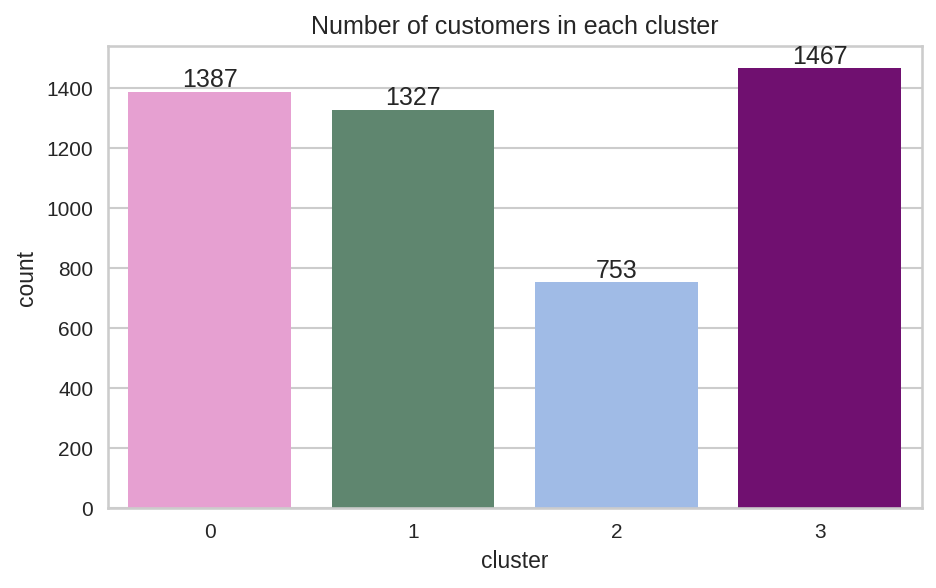

In [ ]:
plt.figure(figsize=(7,4),dpi=150)
cluster_colors = {0:"#f294d6",1:"#588c6e",2: "#94b8f2", 3: "#800080"}
palette = [cluster_colors[int(cluster)] for cluster in sorted(df['cluster'].unique())]
a = sns.countplot(data=df,x='cluster',palette=palette)
for i in a.containers: a.bar_label(i,)
plt.title('Number of customers in each cluster');

- Cluster 3 có số lượng khách hàng cao nhất (1476) và cluster 2 có số lượng thấp nhat

In [ ]:
df["cluster"] = df["cluster"].astype(str)
fig = px.scatter(df.sort_values(by='cluster'), x="Credit_Limit", y="Total_Trans_Amt",
                color='cluster', color_discrete_sequence=cluster_colors, opacity=0.8, symbol='cluster')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Credit Limit")
fig.update_traces(showlegend=True)
fig.update_layout(title="Cluster's Profile Based On Credit Limit and Total Transaction Amount")
fig.show()

- **Cluster 0** (màu hồng):
  - Phân bố chủ yếu ở phía bên trái biểu đồ
  - Các khách hàng có tổng giao dịch nhiều nhất trong khoảng **4K-5K USD** và hạn mức tiêu dùng từ **1438 - khoảng 5K**

- **Cluster 1** (màu xanh lá):
  - Tương tự với Cụm 0 nhưng phần góc dưới bên trái phân bố dày hơn
  - Thêm các khách hàng có tổng giao dịch trong khoảng từ **1K-3K USD**

- **Cluster 2** (màu xanh dương):
  - Phân bố tương tự với 2 cụm trên nhưng có phần đồng đều hơn
  - Hạn mức giao dịch từ **1438 - 5K** phân bố nhiều và giảm dần

- **Cluster 3** (màu tím):
  - Tương tự với Cụm 0, dày đặc nhất ở khu vực tổng lượng giao dịch từ **4K-5K USD** và hạn mức từ **1438 - 5K**

---

**Kết luận**: Thuật toán phân cụm không được rõ ràng ở thuộc tính **tổng lượng giao dịch** và **hạn mức** của khách hàng.


In [ ]:
fig = px.box(df.sort_values(by='cluster'), x="cluster", y="Customer_Age", color='cluster', color_discrete_sequence=cluster_colors, points='all')
fig.update_yaxes(title_text="Customer's Age")
fig.update_xaxes(title_text="Clusters")
fig.update_layout(title = "Boxplots of Clusters based on Customer's Age")
fig.show()

- Mức tuổi của khách hàng trong các cụm không có sự khác biệt đáng kể
- Khoảng tuổi rộng từ 26-65 tuổi, riêng cụm 2 lên đến 68 tuổi.
- Độ tuổi trung vị của các nhóm là 46 và 47 tuổi


In [ ]:
fig = px.box(df.sort_values(by='cluster'), x="cluster", y="Total_Trans_Ct", color='cluster', color_discrete_sequence=cluster_colors, points='all')
fig.update_yaxes(title_text="Total Transaction Count")
fig.update_xaxes(title_text="Clusters")
fig.update_layout(title = "Boxplots of Clusters based on Customer's Total Transaction Count")
fig.show()

- Số lượng giao dịch của các cụm cũng có sự tương đương với nhau, với số lượng từ 10 và cao nhất là 113 giao dịch.
- Số lượng giao dịch trung vị lần lượt ở các cụm là 71, 61, 62, 66

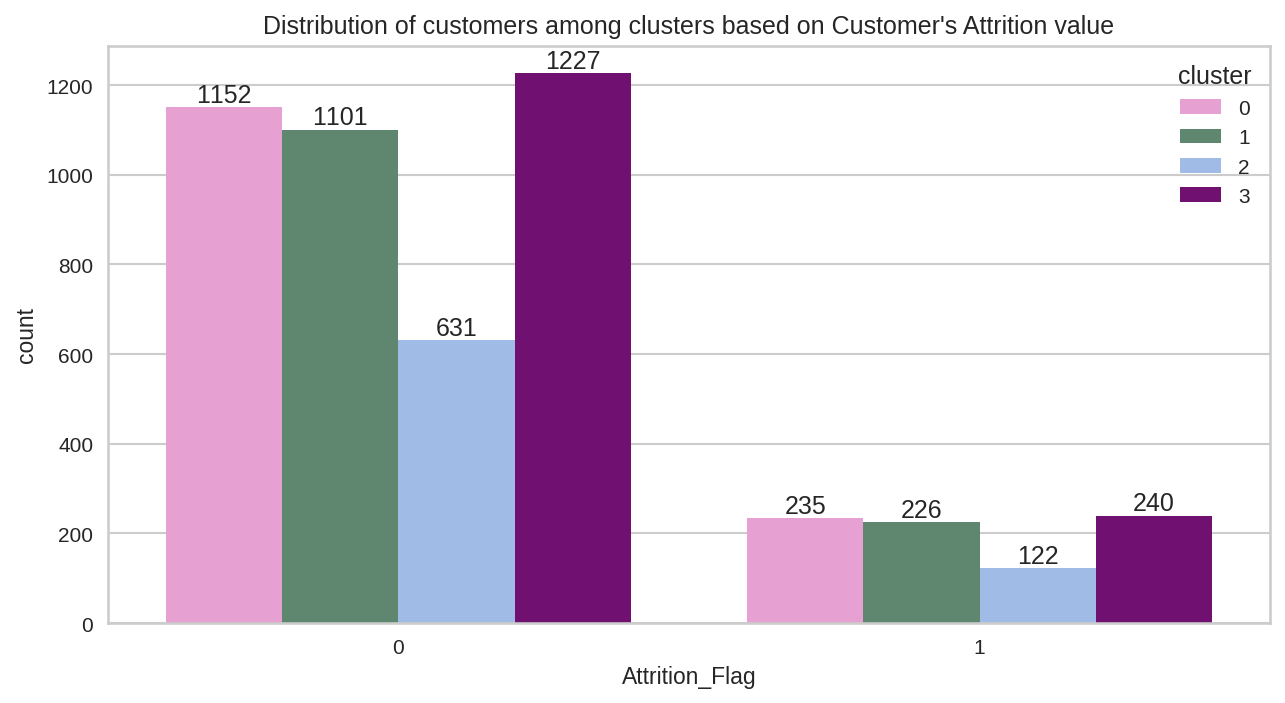

In [ ]:
plt.figure(figsize=(10,5),dpi= 150)
palette = [cluster_colors[int(cluster)] for cluster in sorted(df['cluster'].unique())]
a = sns.countplot(data=df.sort_values(by='cluster'),x='Attrition_Flag',hue='cluster',palette=palette)
for i in a.containers: a.bar_label(i,)
plt.title ("Distribution of customers among clusters based on Customer's Attrition value");

- Vì số lượng khách hàng trong mỗi cụm là tương đương nhau, trừ cụm 2. Tỉ lệ khách hàng ở lại của mỗi cũng gần tương đương nhau.
- Số lượng khách hàng còn ở lại (Atritition_Flag) của cụm 3 là cao nhất so với các cụm khác.

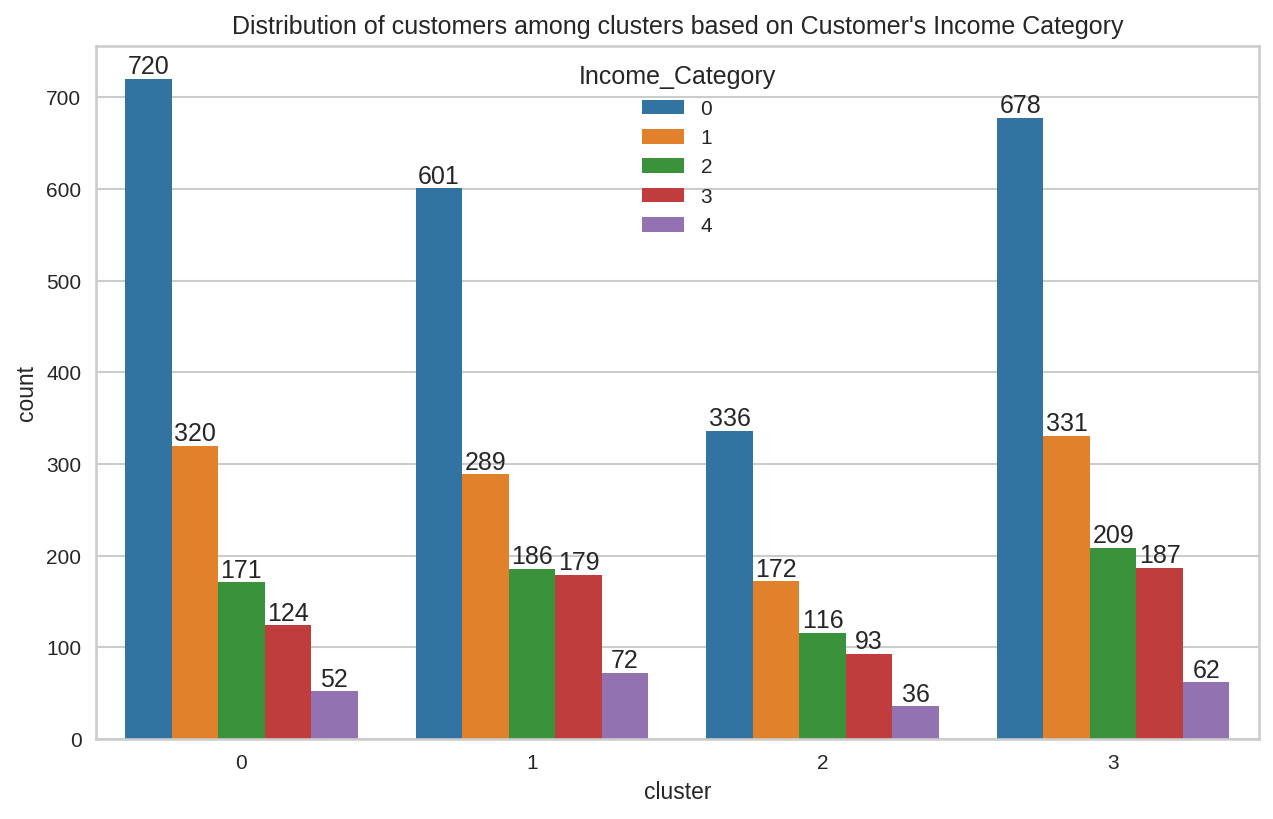

In [ ]:
plt.figure(figsize=(10,6),dpi= 150)
palette = [cluster_colors[int(cluster)] for cluster in sorted(df['cluster'].unique())]
a = sns.countplot(data=df.sort_values(by='cluster'),x='cluster',hue='Income_Category',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.title ("Distribution of customers among clusters based on Customer's Income Category");

Các giá trị Income_Category:
- 0 (Màu xanh dương): Less than 40K
- 1 (Màu cam): 40K-60K
- 2 (Màu xanh lá): 60K-80K
- 3 (Màu đỏ): 80K-120K
- 4 (Màu tím): 120K+  

**Nhận xét:**
- Nhóm thu nhập dưới 40K chiếm ưu thế trong tất cả các cụm, cho thấy rằng nhóm thu nhập này có đại diện cao nhất trong tập dữ liệu.
- Nhóm thu nhập 40K-60K là nhóm có đại diện nhiều thứ hai trong mỗi cụm.
- Các nhóm thu nhập 60K-80K, 80K-120K và trên 120K có số lượng khách hàng tương đối ít hơn trong tất cả các cụm, với đại diện ít nhất là nhóm thu nhập trên $120K.
- Phân cụm không phân tách rõ ràng theo nhóm thu nhập, cho thấy rằng khách hàng từ các nhóm thu nhập thấp được phân bố đều trong tất cả các cụm.

In [ ]:
fig = px.scatter(df, x="Total_Trans_Ct", y="Total_Trans_Amt",
                color='cluster', color_discrete_sequence=colors, opacity=0.8, symbol='cluster')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Total Transaction Count")
fig.update_traces(showlegend=True)
fig.update_layout(title="Cluster's Profile Based On Total Transaction Count and Total Transaction Amoun")
fig.show()

In [ ]:
fig = px.box(df, x="cluster", y="Total_Trans_Amt",
             color='cluster', color_discrete_sequence=colors, points='all')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Clusters")
fig.show()

In [ ]:
fig = px.box(df, x="cluster", y="Credit_Limit", color='cluster', color_discrete_sequence=colors, points='all')
fig.update_yaxes(title_text="Credit Limit")
fig.update_xaxes(title_text="Clusters")
fig.show()

<Figure size 800x550 with 0 Axes>

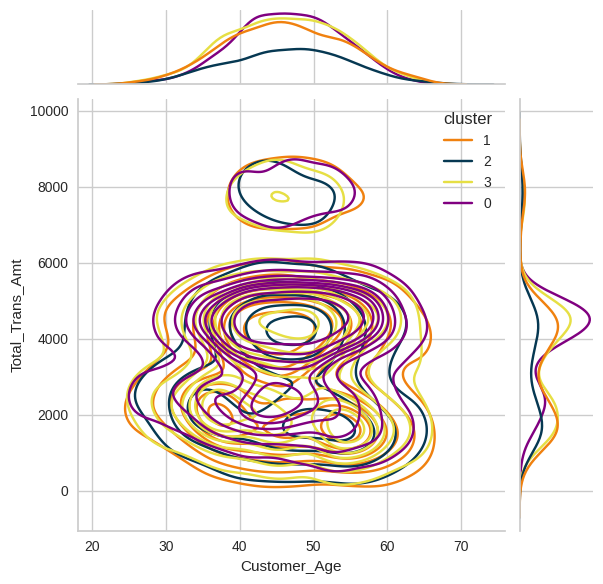

<Figure size 800x550 with 0 Axes>

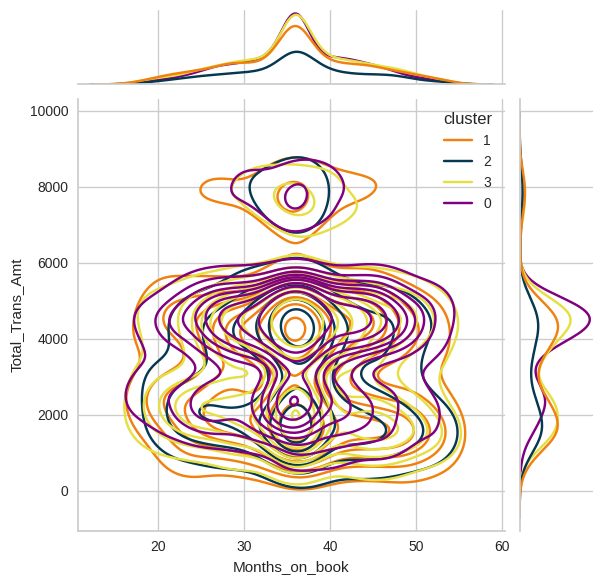

<Figure size 800x550 with 0 Axes>

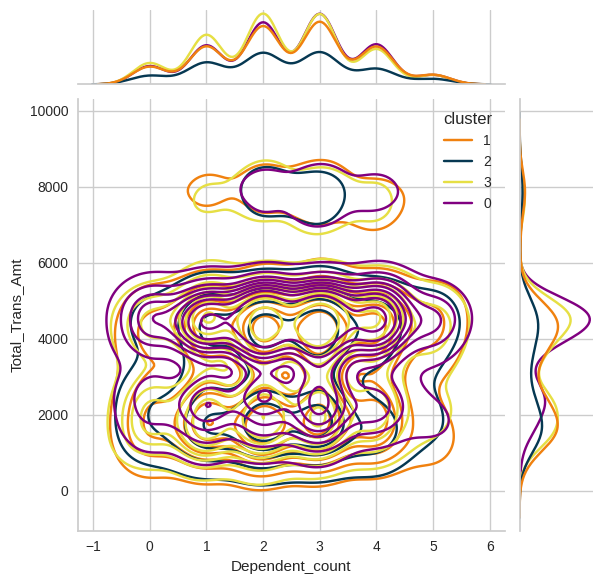

<Figure size 800x550 with 0 Axes>

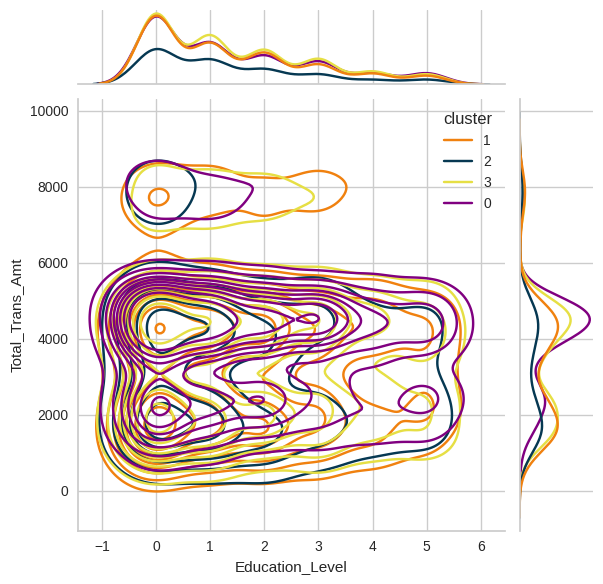

<Figure size 800x550 with 0 Axes>

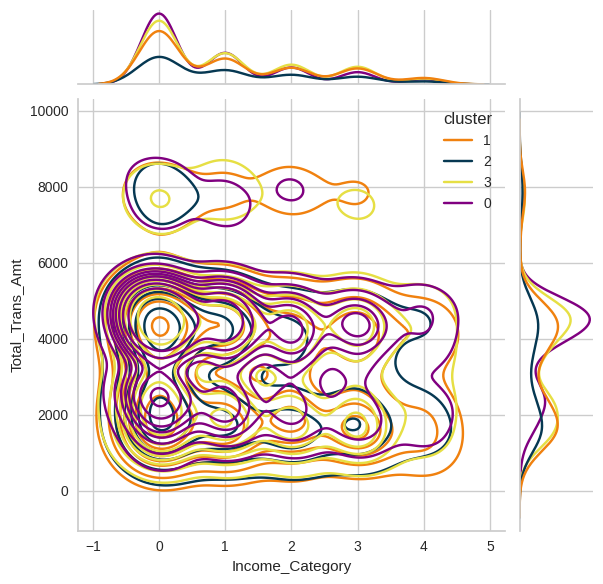

<Figure size 800x550 with 0 Axes>

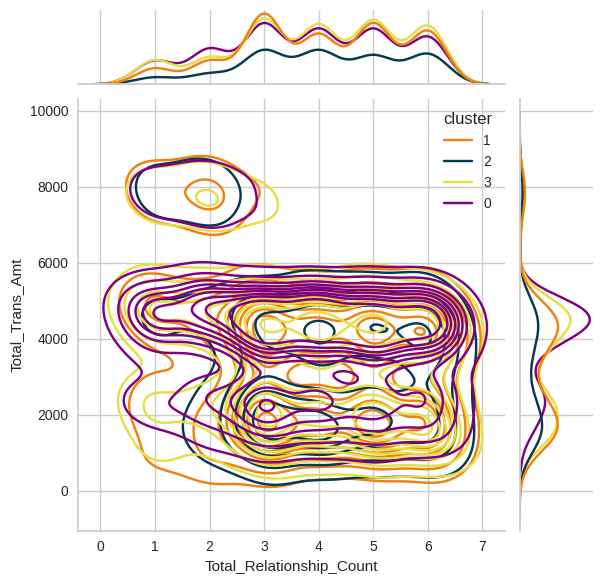

<Figure size 800x550 with 0 Axes>

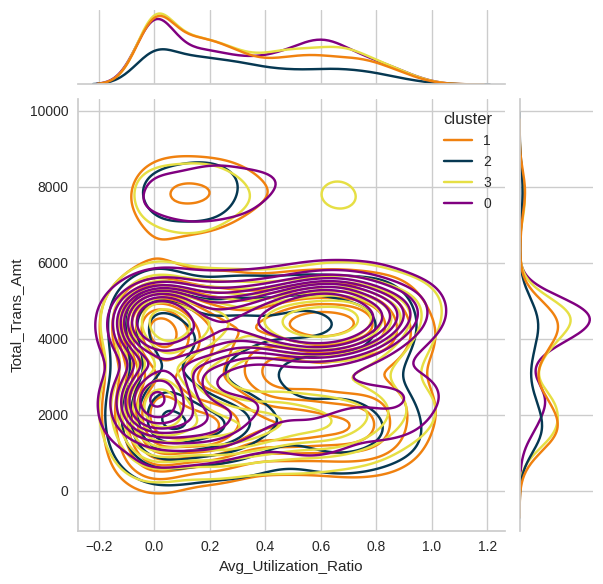

<Figure size 800x550 with 0 Axes>

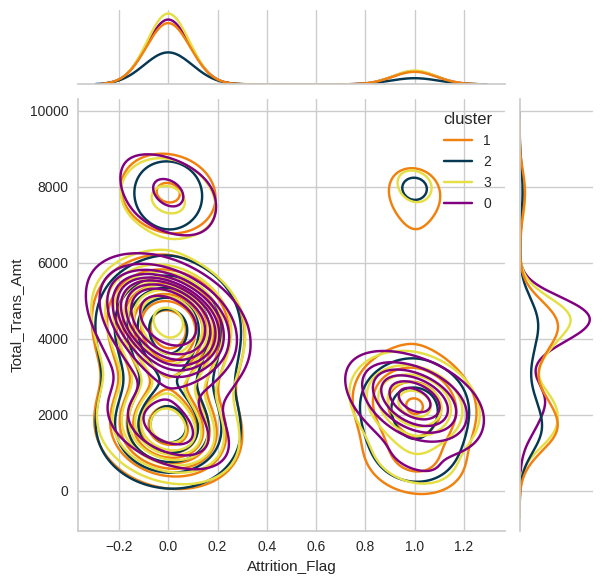

In [ ]:
category = ["Customer_Age", "Months_on_book", "Dependent_count", "Education_Level", "Income_Category", "Total_Relationship_Count", "Avg_Utilization_Ratio", 'Attrition_Flag']

for i in category:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Total_Trans_Amt"], hue =df["cluster"], kind="kde", palette=colors)
    plt.show()

# **3. Kết luận**
- **Cluster 0**:
  - Khách hàng trong nhóm này đa số là những người có thu nhập dưới 40K, số lượng khách hàng ở các mức thu nhập khác cũng cao hơn các nhóm khác.
  - Tỉ lệ khách hàng rời bỏ trong nhóm này thấp
- **Cluster 1**:
  - Số lượng khách hàng có thu thập thấp hơn các nhóm.
  - Tổng lượng giao dịch trung bình ở mức giữa, chứng tỏ các khách hàng này trong giai đoạn chi tiêu nhiều cho cuộc sống.
- **Cluster 2**:
  - Chủ yếu là khách hàng mức thu nhập trung bình
  - Tỉ lệ chưa rời bỏ là cao
  - Mức chi tiêu rất đa dạng
- **Cluster 3**:
  - Nhóm này có nhiều người thu nhập ở mức thấp và cũng nhiều người thu nhập mức cao so với các nhóm còn lại. Nhóm này có thu nhập cao nhất.
  - Mức tuổi của nhóm này thấp hơn các nhóm còn lại

